<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula10a_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-29 22:09:27--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.87.118, 16.182.36.200, 52.217.70.158, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.87.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.4MB/s    in 0.7s    

2024-04-29 22:09:28 (19.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
  data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np
temperature = np.zeros(len(lines))
raw_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

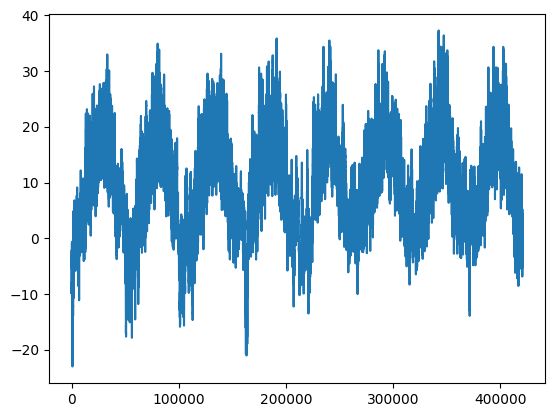

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

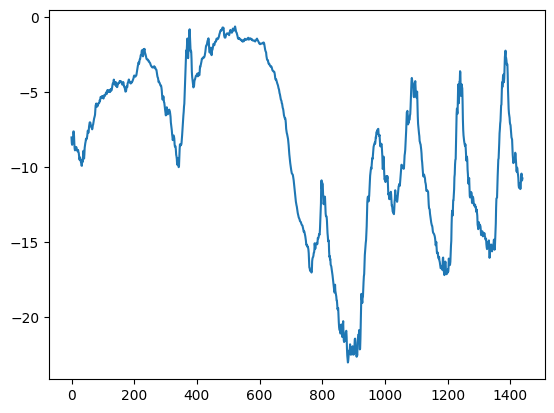

In [6]:
plt.plot(range(1440), temperature[:1440])

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
(num_train_samples, num_val_samples, num_test_samples)

(210225, 105112, 105114)

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [23]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2,
    shuffle = True,
)
for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[1, 2, 3] 4
[4, 5, 6] 7
[3, 4, 5] 6
[2, 3, 4] 5
[0, 1, 2] 3


In [25]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 + 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    end_index = num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

In [27]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (256, 120, 14)
targets shape (256,)


#baseline

In [28]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.76
Test MAE: 2.95


#densely conected

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 36s 41ms/step - loss: 13.8664 - mae: 2.8890 - val_loss: 13.1604 - val_mae: 2.8409
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 10.0932 - mae: 2.5029 - val_loss: 13.6141 - val_mae: 2.9145
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 9.2018 - mae: 2.3870 - val_loss: 11.1427 - val_mae: 2.6307
Epoch 4/10
819/819 [==============================] - 58s 70ms/step - loss: 8.6762 - mae: 2.3192 - val_loss: 11.5760 - val_mae: 2.6849
Epoch 5/10
819/819 [==============================] - 60s 73ms/step - loss: 8.3062 - mae: 2.2681 - val_loss: 11.9379 - val_mae: 2.7208
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 8.0315 - mae: 2.2306 - val_loss: 14.9721 - val_mae: 3.0831
Epoch 7/10
819/819 [==============================] - 57s 70ms/step - loss: 7.7949 - mae: 2.1986 - val_loss: 13.1271 - val_mae: 2.8524
Epoch 8/10
819/819 [==============================] -

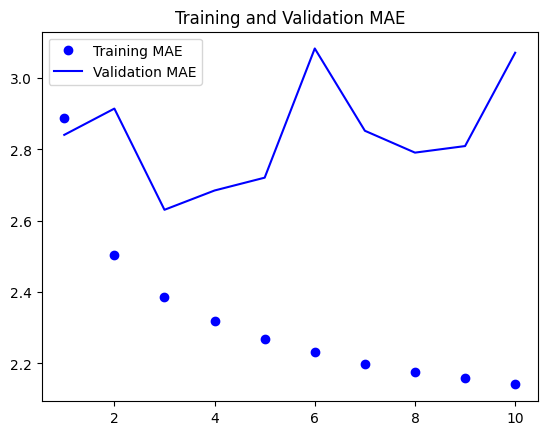

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

#1D convolutional model

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 60ms/step - loss: 22.8184 - mae: 3.7417 - val_loss: 18.4971 - val_mae: 3.4003
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 15.9889 - mae: 3.1817 - val_loss: 15.2278 - val_mae: 3.0785
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 14.7846 - mae: 3.0568 - val_loss: 16.0729 - val_mae: 3.1685
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 13.9350 - mae: 2.9621 - val_loss: 16.9645 - val_mae: 3.2358
Epoch 5/10
819/819 [==============================] - 38s 47ms/step - loss: 13.2454 - mae: 2.8835 - val_loss: 20.6797 - val_mae: 3.5051
Epoch 6/10
819/819 [==============================] - 37s 45ms/step - loss: 12.6603 - mae: 2.8164 - val_loss: 14.6968 - val_mae: 3.0147
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 12.2103 - mae: 2.7618 - val_loss: 15.1419 - val_mae: 3.0486
Epoch 8/10
819/819 [============================

#Rede Recorrente


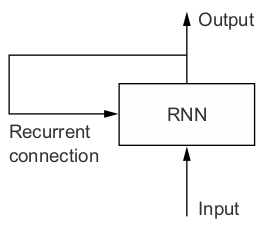

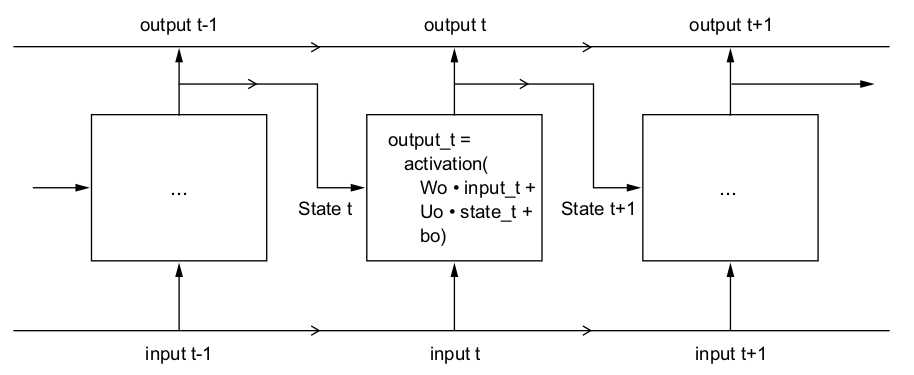

# LSTM

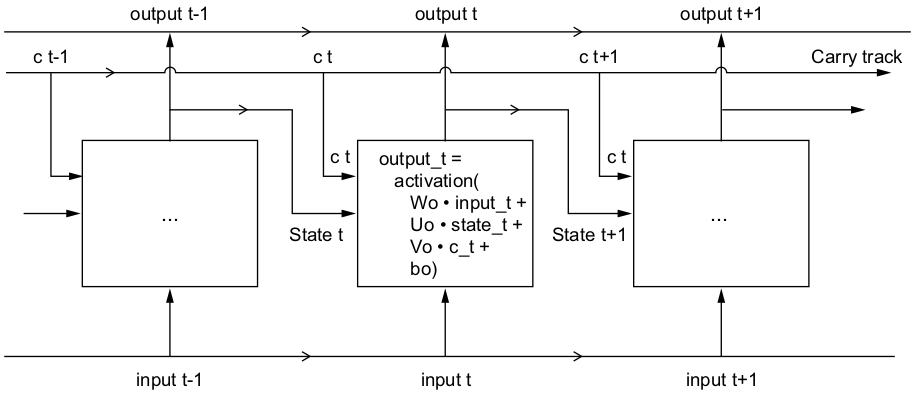

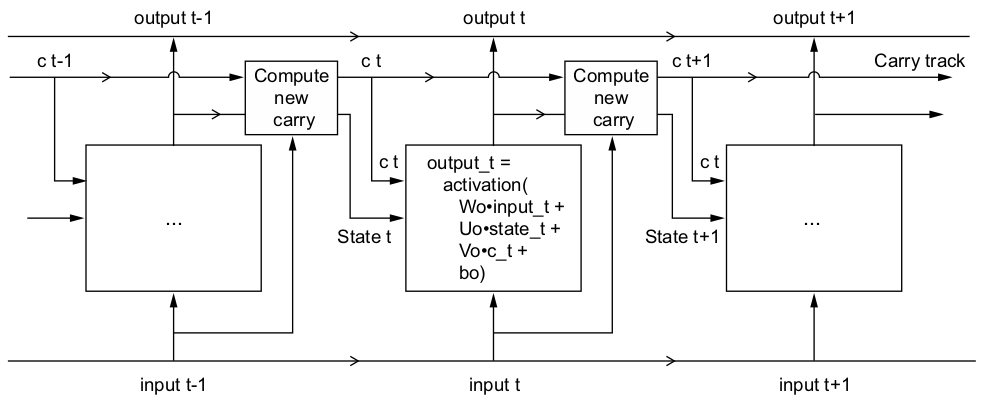

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 41s 48ms/step - loss: 39.6357 - mae: 4.6425 - val_loss: 14.3246 - val_mae: 2.9068
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 12.8415 - mae: 2.8163 - val_loss: 11.3442 - val_mae: 2.6369
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 11.4873 - mae: 2.6669 - val_loss: 11.1784 - val_mae: 2.6065
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 10.8070 - mae: 2.5813 - val_loss: 11.1144 - val_mae: 2.5995
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 10.3585 - mae: 2.5240 - val_loss: 11.1775 - val_mae: 2.5949
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 10.0844 - mae: 2.4906 - val_loss: 11.1948 - val_mae: 2.5953
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 9.8501 - mae: 2.4592 - val_loss: 10.9591 - val_mae: 2.5654
Epoch 8/10
819/819 [=============================

# dropout-regularized LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#bidirectional LSTM

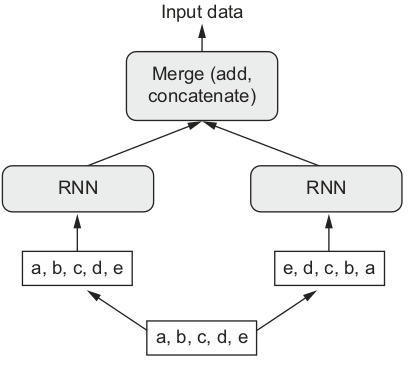

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_bidirectional.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 52ms/step - loss: 28.9950 - mae: 3.9074 - val_loss: 12.0254 - val_mae: 2.7069
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 11.0289 - mae: 2.6037 - val_loss: 11.1403 - val_mae: 2.6087
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 10.0218 - mae: 2.4742 - val_loss: 10.5466 - val_mae: 2.5311
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 9.4099 - mae: 2.4014 - val_loss: 10.6028 - val_mae: 2.5281
Epoch 5/10
819/819 [==============================] - 41s 49ms/step - loss: 8.8519 - mae: 2.3289 - val_loss: 10.5489 - val_mae: 2.5228
Epoch 6/10
819/819 [==============================] - 52s 63ms/step - loss: 8.4654 - mae: 2.2782 - val_loss: 10.9850 - val_mae: 2.5818
Epoch 7/10
819/819 [==============================] - 56s 68ms/step - loss: 8.0779 - mae: 2.2262 - val_loss: 10.8403 - val_mae: 2.5609
Epoch 8/10
819/819 [==============================] 